**Task V: Quantum Graph Neural Network (QGNN)** 
In task II you already worked with a classical GNN. 
Describe a possibility for a QGNN circuit, which takes advantage of the graph representation of the data
Implement and draw the circuit.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.1 MB/s eta 0:00:00:00:0100:01
QGNN output (node embeddings): [-0.025054698171827483, 0.20550554234404717, 0.13769707611736165, -0.1277103615227717, 0.06403689472395035, -0.18929753921429804]

QGNN Explanation:
1. Node Feature Encoding: Node info turned into quantum states using rotations (RX, RY, RZ)
2. Graph Structure Encoding: Graph connections set the entanglement using CNOT gates
3. Message Passing: Info moves around entangled qubits, like in regular 

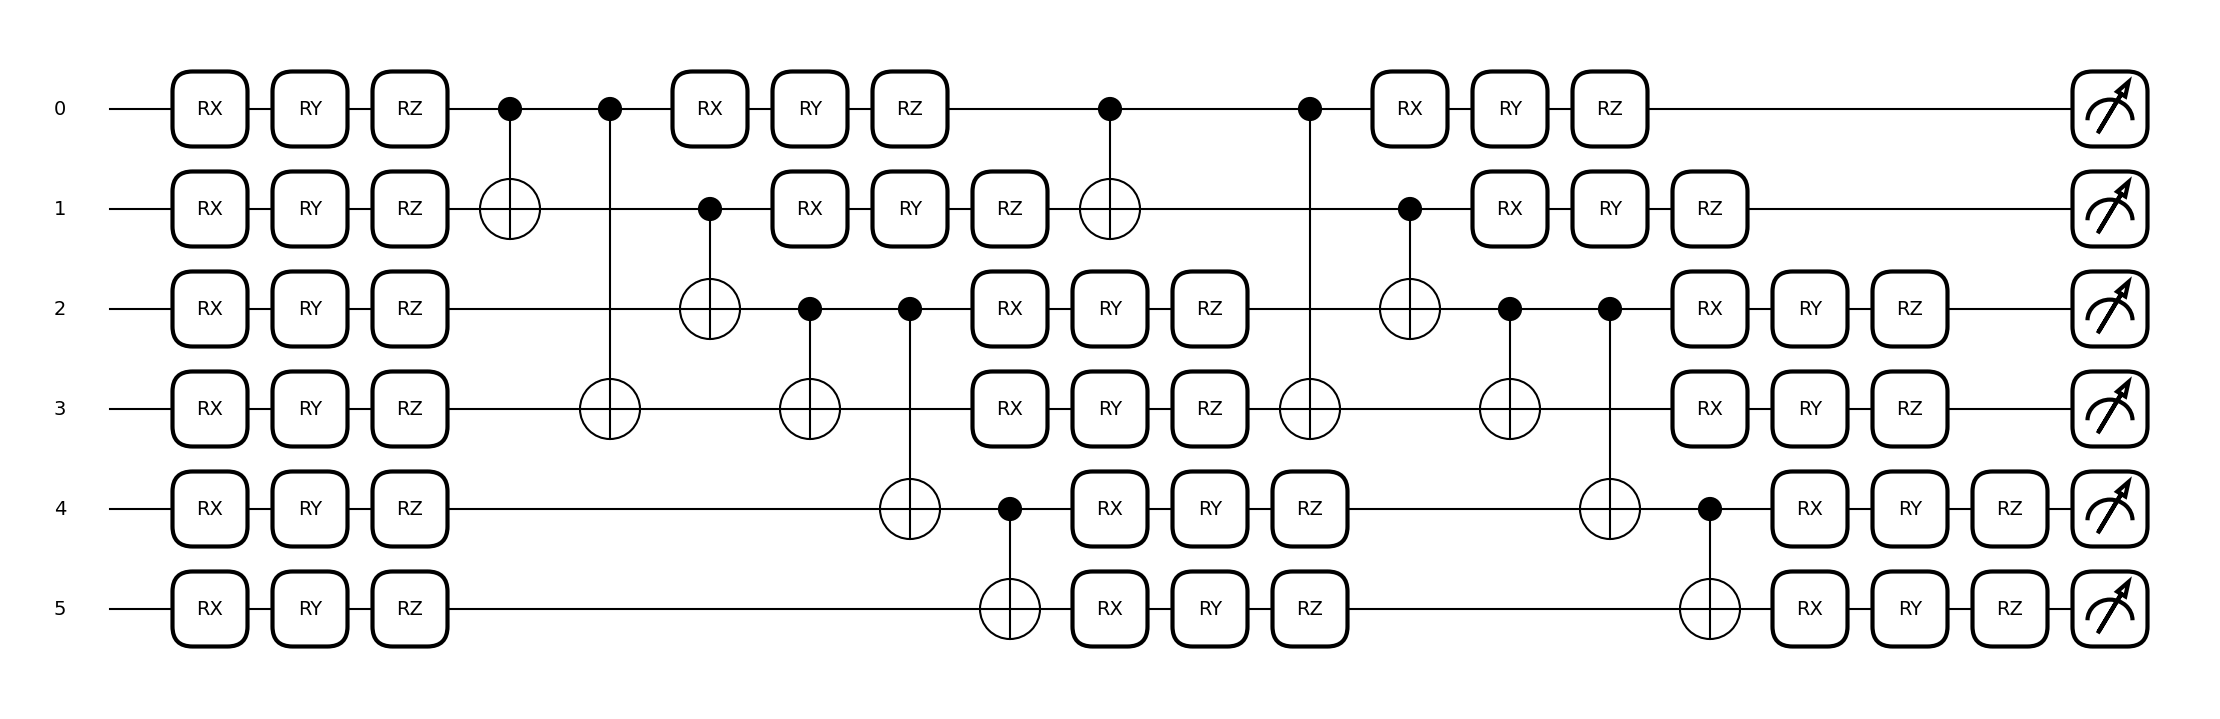

In [1]:
# Install required packages
!pip install pennylane networkx matplotlib numpy scipy

import pennylane as qml
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch
from pennylane import numpy as pnp
import warnings
warnings.filterwarnings("ignore")

# For keeping things consistent
np.random.seed(42)

# Set up qubits and layers
num_qubits = 6 # Nodes in our graph
num_layers = 2

# Make a simple graph
def build_graph():
    graph = nx.Graph()
    # Add nodes with some info
    for i in range(num_qubits):
        graph.add_node(i, features=np.random.uniform(-np.pi, np.pi, 3)) # 3 features for each node

    # Connect the nodes to form a graph
    edges = [(0, 1), (1, 2), (2, 3), (3, 0), (2, 4), (4, 5)]
    graph.add_edges_from(edges)

    return graph

# Create our graph
graph = build_graph()

# Show the graph
plt.figure(figsize=(8, 6))
node_positions = nx.spring_layout(graph, seed=42)
nx.draw(graph, node_positions, with_labels=True, node_color='skyblue', node_size=700, edge_color='black', linewidths=2)
plt.title("Sample Graph Structure")
plt.savefig('graph_structure.png')
plt.close()

# Quantum computer setup
device = qml.device("default.qubit", wires=num_qubits)

# Encode features into quantum state
def encode_node_features(features, qubit_wire):
    # Use rotations for feature encoding
    qml.RX(features[0], wires=qubit_wire)
    qml.RY(features[1], wires=qubit_wire)
    qml.RZ(features[2], wires=qubit_wire)

# Entangle qubits based on graph connections
def connect_graph_nodes(graph_structure):
    for edge in graph_structure.edges():
        qml.CNOT(wires=[edge[0], edge[1]])

# Quantum layer to update node states
def quantum_update_layer(params, layer_index):
    # Rotations on each qubit (node)
    for i in range(num_qubits):
        qml.RX(params[layer_index][i][0], wires=i)
        qml.RY(params[layer_index][i][1], wires=i)
        qml.RZ(params[layer_index][i][2], wires=i)

# QGNN circuit definition
@qml.qnode(device)
def qgnn_circuit(node_feature_data, circuit_params):
    # Start by encoding the node features
    for i, data in enumerate(node_feature_data):
        encode_node_features(data, i)

    # Apply layers of message passing and updates
    for layer in range(len(circuit_params)):
        # Entangle connected nodes
        connect_graph_nodes(graph)

        # Update node states with a quantum layer
        quantum_update_layer(circuit_params, layer)

    # Measure each qubit in Z-basis
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Set up random parameters for the quantum circuit
def initialize_params(num_layers, num_qubits):
    # Params for each layer, qubit, and rotation
    return np.random.uniform(-np.pi, np.pi, (num_layers, num_qubits, 3))

# Initialize parameters
params = initialize_params(num_layers, num_qubits)

# Get node features from the graph
node_features = np.array([graph.nodes[i]['features'] for i in range(num_qubits)])

# Run the QGNN circuit
output_embeddings = qgnn_circuit(node_features, params)
print("QGNN output (node embeddings):", output_embeddings)

# Draw the quantum circuit
fig, ax = qml.draw_mpl(qgnn_circuit)(node_features, params)
plt.figure(figsize=(12, 8))
plt.title("QGNN Circuit")
fig.tight_layout()
plt.savefig('qgnn_circuit.png')
plt.close()

# Visualize QGNN structure
def show_qgnn_architecture():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Node positions for drawing
    node_positions = {
        0: (1, 5),
        1: (3, 5),
        2: (5, 5),
        3: (1, 3),
        4: (3, 3),
        5: (5, 3)
    }

    # x-coords for stages: Encoding, Passing, Readout
    stage_x_coords = [2, 6, 10]

    # Draw nodes for each stage
    for node, pos in node_positions.items():
        # Initial node features
        circle = Circle((stage_x_coords[0], pos[1]), 0.3, color='skyblue', alpha=0.8)
        ax.add_patch(circle)
        ax.text(stage_x_coords[0], pos[1], f"{node}", ha='center', va='center')

        # After message passing
        circle = Circle((stage_x_coords[1], pos[1]), 0.3, color='lightgreen', alpha=0.8)
        ax.add_patch(circle)
        ax.text(stage_x_coords[1], pos[1], f"{node}'", ha='center', va='center')

        # Readout
        circle = Circle((stage_x_coords[2], pos[1]), 0.3, color='salmon', alpha=0.8)
        ax.add_patch(circle)
        ax.text(stage_x_coords[2], pos[1], f"M{node}", ha='center', va='center')

    # Graph edges from before
    edges_list = [(0, 1), (1, 2), (2, 3), (3, 0), (2, 4), (4, 5)]

    for edge in edges_list:
        node1, node2 = edge
        # Edges in the first stage
        ax.add_patch(ConnectionPatch(
            (stage_x_coords[0], node_positions[node1][1]),
            (stage_x_coords[0], node_positions[node2][1]),
            "data", "data",
            arrowstyle="-",
            color="black"
        ))

        # Quantum links in message passing stage
        ax.add_patch(ConnectionPatch(
            (stage_x_coords[1], node_positions[node1][1]),
            (stage_x_coords[1], node_positions[node2][1]),
            "data", "data",
            arrowstyle="-",
            linestyle="dotted",
            linewidth=2,
            color="purple"
        ))

    # Connect stages for each node
    for node, pos in node_positions.items():
        # Encoding to message passing
        ax.add_patch(ConnectionPatch(
            (stage_x_coords[0]+0.3, pos[1]),
            (stage_x_coords[1]-0.3, pos[1]),
            "data", "data",
            arrowstyle="->",
            color="blue"
        ))

        # Message passing to readout
        ax.add_patch(ConnectionPatch(
            (stage_x_coords[1]+0.3, pos[1]),
            (stage_x_coords[2]-0.3, pos[1]),
            "data", "data",
            arrowstyle="->",
            color="red"
        ))

    # Stage labels
    ax.text(stage_x_coords[0], 6.5, "Feature Encoding", ha='center', fontsize=14)
    ax.text(stage_x_coords[1], 6.5, "Quantum Message Passing", ha='center', fontsize=14)
    ax.text(stage_x_coords[2], 6.5, "Measurement (Readout)", ha='center', fontsize=14)

    # Adjust view and remove ticks
    ax.set_xlim(0, 12)
    ax.set_ylim(2, 7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Quantum Graph Neural Network Architecture", fontsize=16)

    plt.savefig('qgnn_architecture.png')
    plt.close()

# Show QGNN architecture visualization
show_qgnn_architecture()

# How QGNN works with graph data explained
print("\nQGNN Explanation:")
print("1. Node Feature Encoding: Node info turned into quantum states using rotations (RX, RY, RZ)")
print("2. Graph Structure Encoding: Graph connections set the entanglement using CNOT gates")
print("3. Message Passing: Info moves around entangled qubits, like in regular GNNs")
print("4. Node Updates: Quantum gates with learnable params update each node's quantum state")
print("5. Readout: Measure to get node info or graph predictions")
print("\nIn short, graph structure is part of the quantum circuit:")
print("- Node features → Quantum states")
print("- Edges → Entanglement")
print("- Message aggregation → Quantum effects")
print("- Node updates → Quantum gates with parameters")